In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12150.18it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, ConvDepthEncoder, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [ ]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []

    for upd in range(total_updates):
        buf = RolloutBuffer()

        for mb in range(MINIBATCHES):

            # ---- episode rollout data ----
            episode_seq = []
            episode_reward = 0
            actions_seq = []

            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    rgb_t = ppo.obs_from_event(event)    # (3,H,W)
                    rgb_t = rgb_t.unsqueeze(0).unsqueeze(0)  # (1,1,3,H,W)
                    rgb_embed = actor_critic.rgb_encoder(rgb_t).squeeze(0).squeeze(0)


                depth_np = event.depth_frame  # (H, W) numpy
                depth_t = torch.from_numpy(depth_np.copy()).float().unsqueeze(0).unsqueeze(0).unsqueeze(0)  # (B,S,1,H,W)
                depth_t = depth_t.to(DEVICE) / 255.0  # normalize

                with torch.no_grad():
                    depth_embed = actor_critic.depth_encoder(depth_t).squeeze(0).squeeze(0)

                fused_embed_t = torch.cat([rgb_embed, depth_embed], dim=-1)  # (2*D)

                episode_seq.append(fused_embed_t)

                obs_seq = torch.stack(episode_seq, dim=0).unsqueeze(0).to(DEVICE)  # (1, S, 2D)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)

                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample().item()
                logp = dist.log_prob(torch.tensor(action_idx, device=DEVICE)).item()

                event, reward = env.step_env(controller, action_idx)
                done = (t == EPISODE_STEPS)

                buf.add(
                    rgb_embed=rgb_embed,
                    depth_embed=depth_embed,  # NEW
                    action_idx=action_idx,
                    logp=logp,
                    reward=reward,
                    value=value,
                    done=done
                )

                rewards.append(reward)
                actions_seq.append(action_idx)
                episode_reward += reward / EPISODE_STEPS


                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)

        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")

    return buf, rewards, episode_rewards


In [7]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
depth_encoder = ConvDepthEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, depth_encoder, actor, critic)


/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=80.6038, Policy=0.0052, Value=161.3009
[PPO] Epoch 10: Loss=59.4747, Policy=0.0215, Value=119.0040
[PPO] Epoch 20: Loss=47.8479, Policy=0.0007, Value=95.7976
[PPO] Epoch 30: Loss=41.2162, Policy=-0.0005, Value=82.5379
Approx KL Learned: 0.014785533770918846
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=86.7908, Policy=0.0018, Value=173.6813
[PPO] Epoch 10: Loss=79.3098, Policy=-0.0030, Value=158.7275
[PPO] Epoch 20: Loss=73.2173, Policy=-0.0020, Value=146.5397
[PPO] Epoch 30: Loss=69.3914, Policy=-0.0008, Value=138.8866
Approx KL Learned: 0.009090336039662361
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=72.3211, Policy=0.0015, Value=144.7412
[PPO] Epoch 10: Loss=60.9018, Policy=-0.0059, Value=121.9131
[PPO] Epoch 20: Loss=57.5350, Policy=-0.0047, Value=115.1796
[PPO] Epoch 30: Loss=52.7647, Policy=-0.0069, Value=105.6422
Approx KL Learned: 0.01764722913503647
[✅] Actor-Criti

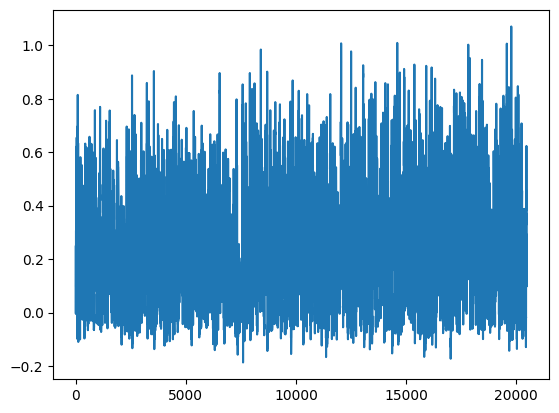

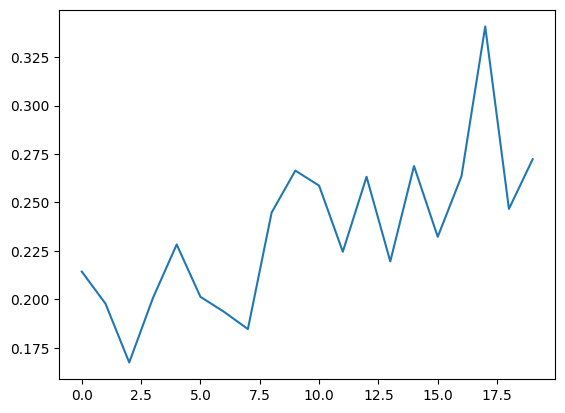

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=96.6053, Policy=0.0003, Value=193.3058
[PPO] Epoch 10: Loss=76.1124, Policy=-0.0024, Value=152.3232
[PPO] Epoch 20: Loss=69.6221, Policy=-0.0040, Value=139.3440
[PPO] Epoch 30: Loss=62.1511, Policy=-0.0094, Value=124.4129
Approx KL Learned: 0.01721773110330105
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=72.9583, Policy=0.0016, Value=146.0070
[PPO] Epoch 10: Loss=58.3110, Policy=-0.0147, Value=116.7387
[PPO] Epoch 20: Loss=52.4571, Policy=-0.0154, Value=105.0280
[PPO] Epoch 30: Loss=47.8161, Policy=-0.0120, Value=95.7465
Approx KL Learned: 0.026562925428152084
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=47.1623, Policy=0.0002, Value=94.4098
[PPO] Epoch 10: Loss=39.3809, Policy=-0.0039, Value=78.8512
[PPO] Epoch 20: Loss=35.0818, Policy=-0.0131, Value=70.2672
[PPO] Epoch 30: Loss=32.3521, Policy=-0.0184, Value=64.8167
Approx KL Learned: 0.03896741569042206
[✅] Actor-Critic 

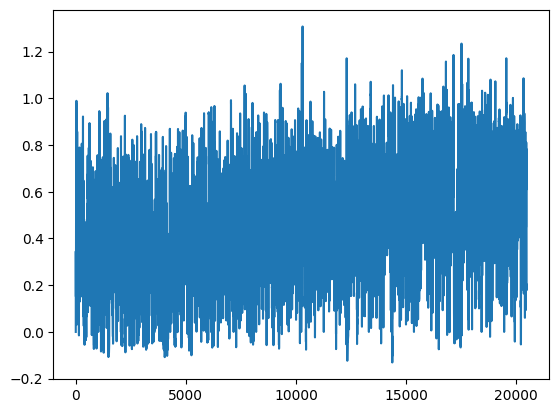

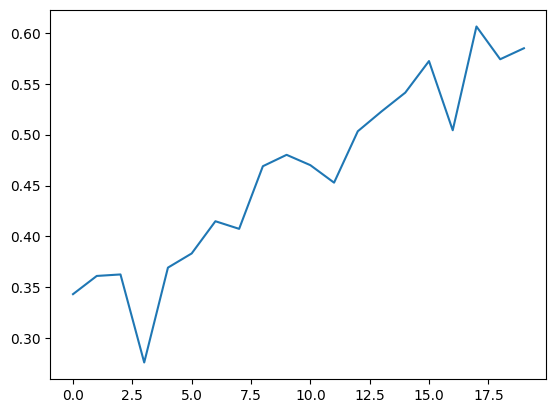

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=82.8867, Policy=0.0020, Value=165.8095
[PPO] Epoch 10: Loss=61.9301, Policy=0.0325, Value=123.8642
[PPO] Epoch 20: Loss=43.6327, Policy=0.0044, Value=87.2920
[PPO] Epoch 30: Loss=37.5427, Policy=-0.0004, Value=75.1357
Approx KL Learned: 0.008565325289964676
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=62.0868, Policy=0.0007, Value=124.2180
[PPO] Epoch 10: Loss=44.8893, Policy=-0.0006, Value=89.8355
[PPO] Epoch 20: Loss=32.1143, Policy=-0.0042, Value=64.2898
[PPO] Epoch 30: Loss=26.1981, Policy=-0.0033, Value=52.4544
Approx KL Learned: 0.008928848430514336
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=70.0095, Policy=0.0015, Value=140.0684
[PPO] Epoch 10: Loss=55.3147, Policy=-0.0007, Value=110.6939
[PPO] Epoch 20: Loss=51.5086, Policy=-0.0073, Value=103.0881
[PPO] Epoch 30: Loss=44.3393, Policy=-0.0050, Value=88.7503
Approx KL Learned: 0.017850123345851898
[✅] Actor-Critic c

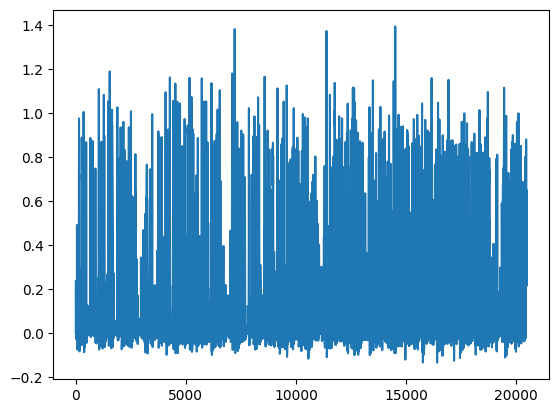

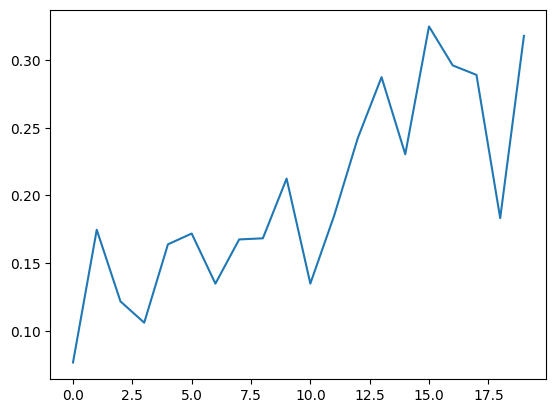

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=55.8430, Policy=0.0028, Value=111.7362
[PPO] Epoch 10: Loss=30.8432, Policy=-0.0014, Value=61.7475
[PPO] Epoch 20: Loss=23.2367, Policy=-0.0010, Value=46.5380
[PPO] Epoch 30: Loss=19.6630, Policy=-0.0030, Value=39.3934
Approx KL Learned: 0.05049024149775505
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=41.4971, Policy=0.0004, Value=83.0611
[PPO] Epoch 10: Loss=38.6231, Policy=-0.0017, Value=77.3161
[PPO] Epoch 20: Loss=30.4431, Policy=-0.0012, Value=60.9573
[PPO] Epoch 30: Loss=25.7502, Policy=-0.0003, Value=51.5708
Approx KL Learned: 0.008998136967420578
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=44.7646, Policy=0.0010, Value=89.5887
[PPO] Epoch 10: Loss=41.1873, Policy=0.0008, Value=82.4389
[PPO] Epoch 20: Loss=29.7594, Policy=-0.0007, Value=59.5855
[PPO] Epoch 30: Loss=24.3776, Policy=-0.0021, Value=48.8246
Approx KL Learned: 0.012705272063612938
[✅] Actor-Critic checkp

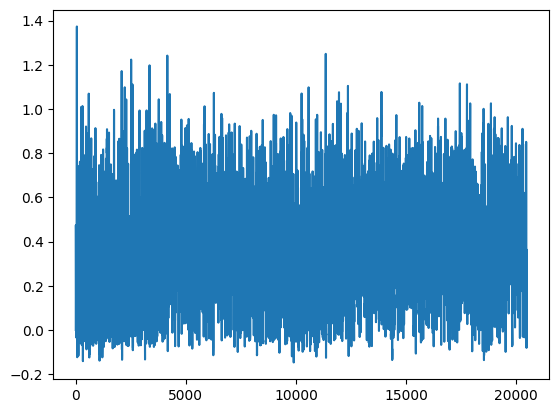

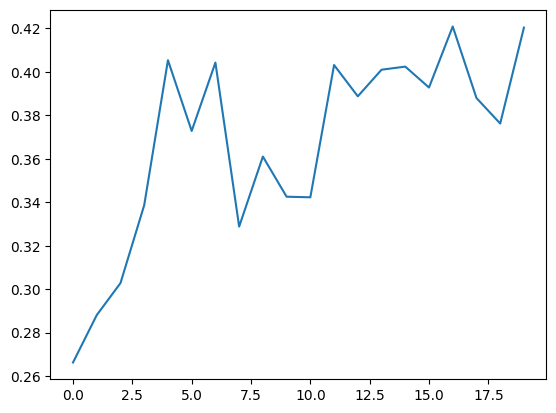

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=78.3258, Policy=0.0029, Value=156.7082
[PPO] Epoch 10: Loss=49.5307, Policy=-0.0019, Value=99.1276
[PPO] Epoch 20: Loss=41.9359, Policy=-0.0036, Value=83.9432
[PPO] Epoch 30: Loss=39.3817, Policy=-0.0056, Value=78.8397
Approx KL Learned: 0.011309769004583359
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=54.1665, Policy=0.0005, Value=108.3948
[PPO] Epoch 10: Loss=36.5160, Policy=-0.0006, Value=73.0962
[PPO] Epoch 20: Loss=25.5490, Policy=-0.0022, Value=51.1644
[PPO] Epoch 30: Loss=19.1916, Policy=-0.0062, Value=38.4594
Approx KL Learned: 0.014918738976120949
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=77.8284, Policy=0.0012, Value=155.7161
[PPO] Epoch 10: Loss=49.8704, Policy=-0.0009, Value=99.8046
[PPO] Epoch 20: Loss=38.1246, Policy=-0.0039, Value=76.3205
[PPO] Epoch 30: Loss=31.8072, Policy=-0.0053, Value=63.6884
Approx KL Learned: 0.017354032024741173
[✅] Actor-Critic ch

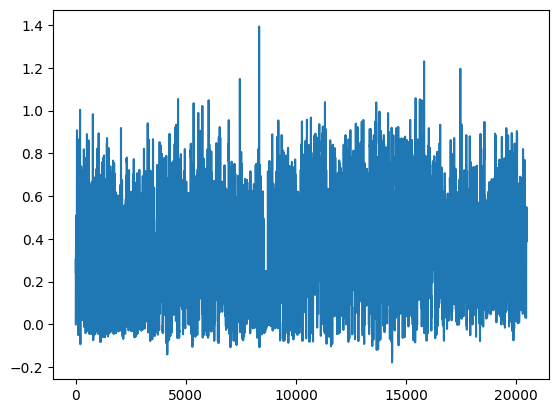

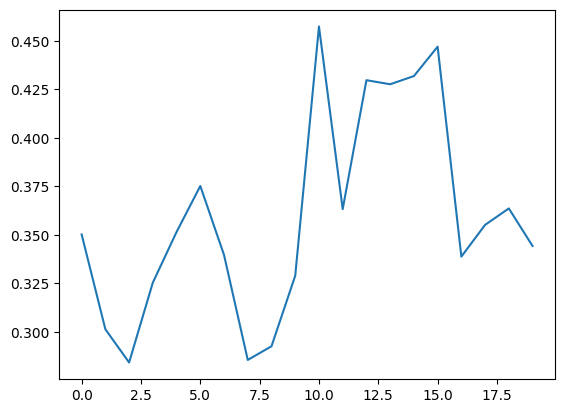

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=72.4699, Policy=0.0025, Value=145.0070
[PPO] Epoch 10: Loss=44.4767, Policy=-0.0074, Value=89.0374
[PPO] Epoch 20: Loss=31.0799, Policy=-0.0104, Value=62.2488
[PPO] Epoch 30: Loss=23.3287, Policy=-0.0079, Value=46.7419
Approx KL Learned: 0.016536908224225044
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=64.0670, Policy=0.0018, Value=128.1985
[PPO] Epoch 10: Loss=35.9851, Policy=-0.0068, Value=72.0485
[PPO] Epoch 20: Loss=23.8253, Policy=-0.0100, Value=47.7343
[PPO] Epoch 30: Loss=18.9750, Policy=-0.0117, Value=38.0372
Approx KL Learned: 0.011703994125127792
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096


In [ ]:
from ai2thor.controller import Controller

NUM_ENV = 100
for i in range(NUM_ENV):
    try:
        rand_env = torch.randint(0, len(dataset["train"]), (1,)).item()
        house = dataset["train"][rand_env]
        controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30, renderDepthImage=True)
        teleport(controller)
        buf, rewards, episode_rewards = train(controller, "weight.pt", ppo, clip_env, clip_actor_critic, 5)
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    finally:
        controller.stop()


In [62]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=256
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame[:, :, ::-1])   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
inference_video_mp4(get_distributions, init_pos, clip_env, clip_actor_critic)

[🎞️] Saved video to rollout.mp4


[[1.0985212326049805, 1.6973028182983398],
 [1.0985212326049805, 1.9473028182983398],
 [1.0985212326049805, 2.19730281829834],
 [1.0985212326049805, 2.44730281829834],
 [1.0985212326049805, 2.44730281829834],
 [0.9735212326049805, 2.663809061050415],
 [0.9735212326049805, 2.663809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 2.788809061050415],
 [0.7570148706436157, 3.038809061050415],
 [0.7570148706436157, 3.038809061050415],
 [0.8820148706436157, 3.2553153038024902],
 [0.8820148706436157, 3.2553153038024902],
 [1.0985212326049805, 3.3803153038024902],
 [1.0985212326049805, 3.3803153038024902],
 [1.0985212326049805, 3.3803153

In [34]:
!pip install imageio imageio-ffmpeg

In [22]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [23]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.877001953125
Rand: 0.86337890625
Policy: 0.87021484375
Rand: 0.8068359375
Policy: 0.83388671875
Rand: 0.845361328125
Policy: 0.8791015625
Rand: 0.876318359375
Policy: 0.80693359375
Rand: 0.79033203125


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>